In [2]:
import pandas as pd
import numpy as np

In [3]:
# Dataframes from Census-Data
census_column_keys = pd.read_csv("../shared_data_read_only/Census-Data/ACSST5Y2022.S2201-Column-Metadata.csv")
census_data = pd.read_csv("../shared_data_read_only/Census-Data/ACSST5Y2022.S2201-Data.csv", low_memory=False)
nonprofit_data = pd.read_csv("../shared_data_read_only/Census-Data/Nonprofit_Data_PA.csv")

In [4]:
# Dataframes from Education-Data
enrollment_demographics = pd.read_csv("../shared_data_read_only/Education-Data/2023-2024 Enrollment & Demographics.csv")
master_school_list = pd.read_csv("../shared_data_read_only/Education-Data/2023-2024 Master School List (20231003).csv")
college_matriculation = pd.read_csv("../shared_data_read_only/Education-Data/SDP_College_Matriculation_2021-2022.csv")
graduation_rates = pd.read_csv("../shared_data_read_only/Education-Data/SDP_Graduation_Rates_School_S_2023-02-15.csv")
school_metrics = pd.read_csv("../shared_data_read_only/Education-Data/SPREE_SY2122_School_Metric_Scores.csv")
student_ada = pd.read_csv("../shared_data_read_only/Education-Data/Student_ADA_Yearly.csv")

In [5]:
# Dataframes from Geography-Mapping
geography_map = pd.read_csv("../shared_data_read_only/Geography-Mapping/ZIP_TRACT_122023.csv")

In [6]:
#Clean and merge the census data

#check if NAME column contains "Pennsylvania"
#list(census_data.columns)
PA_census_data = census_data[census_data['NAME'].str.contains('Pennsylvania')]
print(PA_census_data.shape[0]) #this has 3446 because of multiple tracts

#remove the leading "1400000US" in front to extract the tract number
PA_census_data.loc[:, 'GEO_ID'] = PA_census_data['GEO_ID'].str.replace('1400000US', '')
PA_census_renamed = PA_census_data.rename({'GEO_ID' : 'TRACT'}, axis=1)

#filter down the geography map
PA_geography_map = geography_map[geography_map['USPS_ZIP_PREF_STATE'].str.contains('PA')]
print(PA_geography_map.shape[0]) #8907 values, greater than our 3446 so not every tract is represented


3446
8907


In [7]:
#convert TRACT numbers to strings
PA_census_renamed['TRACT'] = PA_census_renamed['TRACT'].astype(str)
PA_geography_map.loc[:, 'TRACT'] = PA_geography_map['TRACT'].astype(str)

#map the tract number to the zip code
merged_census = pd.merge(PA_census_renamed, PA_geography_map, on='TRACT', how='left')

#move zip to be 1st column
columns = ['ZIP'] + [col for col in merged_census.columns if col != 'ZIP']

#reassign the column order
merged_census = merged_census[columns] #contains census data and geographical information so far

# sort by zip code so we can see what is happening and how to collapse
merged_census.sort_values(by='ZIP', ascending=True, inplace=True)

print(merged_census.shape[0])
print(merged_census.head(10))

#convert object types to numeric data
object_cols = merged_census.select_dtypes(include=['object']).columns

for col in object_cols:
    merged_census[col] = pd.to_numeric(merged_census[col], errors='coerce')

#get the numeric columns only
numeric_cols = merged_census.select_dtypes(include=[np.float64, np.float32]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['ZIP', 'Unnamed: 458']]

# make sure zip is not part of the averaging columns
print("Columns for averaging:", numeric_cols)


# collpase by averageing out the values in each column
collapsed_data = merged_census.groupby('ZIP')[numeric_cols].median().reset_index()

print(collapsed_data.shape[0])
print(collapsed_data.head(10))

/tmp/ipykernel_101170/2936731038.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['42007605002' '42007604901' '42003449000' ... '42011002600' '42011002900'
 '42011000600']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  PA_geography_map.loc[:, 'TRACT'] = PA_geography_map['TRACT'].astype(str)


8908
          ZIP        TRACT                                               NAME  \
1101  15001.0  42007604901  Census Tract 6049.01; Beaver County; Pennsylvania   
1064  15001.0  42007602900     Census Tract 6029; Beaver County; Pennsylvania   
1068  15001.0  42007603000     Census Tract 6030; Beaver County; Pennsylvania   
1073  15001.0  42007603202  Census Tract 6032.02; Beaver County; Pennsylvania   
1128  15001.0  42007605500     Census Tract 6055; Beaver County; Pennsylvania   
1104  15001.0  42007605001  Census Tract 6050.01; Beaver County; Pennsylvania   
1103  15001.0  42007604902  Census Tract 6049.02; Beaver County; Pennsylvania   
1107  15001.0  42007605002  Census Tract 6050.02; Beaver County; Pennsylvania   
1133  15001.0  42007605700     Census Tract 6057; Beaver County; Pennsylvania   
1099  15001.0  42007604800     Census Tract 6048; Beaver County; Pennsylvania   

     S2201_C01_001E S2201_C01_001M S2201_C01_002E S2201_C01_002M  \
1101           1636            141 

In [8]:
merged_census.head(5)

,ZIP,TRACT,NAME,S2201_C01_001E,S2201_C01_001M,S2201_C01_002E,S2201_C01_002M,S2201_C01_003E,S2201_C01_003M,S2201_C01_004E,...,S2201_C06_037M,S2201_C06_038E,S2201_C06_038M,Unnamed: 458,USPS_ZIP_PREF_CITY,USPS_ZIP_PREF_STATE,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
1101,15001.0,42007604901,NaN,1636,141,858,146,778,169,840,...,8.9,69.0,8.8,NaN,NaN,NaN,0.109431,0.092672,0.102778,0.108464
1064,15001.0,42007602900,NaN,1026,145,527,114,499,89,641,...,6.7,54.8,8.3,NaN,NaN,NaN,0.009269,0.000000,0.005556,0.008733
1068,15001.0,42007603000,NaN,1075,74,535,85,540,82,643,...,5.8,62.5,7.8,NaN,NaN,NaN,0.062855,0.029095,0.005556,0.060054
1073,15001.0,42007603202,NaN,2952,252,1424,249,1528,205,1867,...,8.4,53.4,7.9,NaN,NaN,NaN,0.108678,0.066810,0.150000,0.107385
1128,15001.0,42007605500,NaN,2191,225,1069,237,1122,200,1248,...,10.4,54.2,11.5,NaN,NaN,NaN,0.030298,0.050647,0.061111,0.031914


In [9]:
# Dropping unnecessary rows from enrollment_demographics dataframe.
updated_enrollment_demographics = enrollment_demographics.loc[enrollment_demographics['GradeLevel'] == 'All Grades']
print(len(updated_enrollment_demographics))

331


In [10]:
updated_student_ada = student_ada.loc[student_ada['School Year'] == '2021-2022']
print(len(updated_student_ada))

214


In [11]:
# Dropping unnecessary rows from updated_graduation_rates dataframe.
print(len(graduation_rates))
graduation_rates['score'] = pd.to_numeric(graduation_rates['score'], errors='coerce')
updated_cleaned_data = graduation_rates.dropna(subset=['score'])
updated_graduation_rates = updated_cleaned_data.groupby(['schoolid_ulcs', 'schoolname', 'sector', 'rate_type', 'group', 'subgroup'])['score'].mean().reset_index()
updated_graduation_rates.rename(columns={'score': 'average_score'}, inplace=True)
updated_graduation_rates = updated_graduation_rates.loc[updated_graduation_rates['group'] == 'All Students']
updated_graduation_rates = updated_graduation_rates.loc[updated_graduation_rates['rate_type'] == '4-Year Graduation Rate']
print(len(updated_graduation_rates))
updated_graduation_rates.head(5)

26163
95


,schoolid_ulcs,schoolname,sector,rate_type,group,subgroup,average_score
0,1010,John Bartram High School,District,4-Year Graduation Rate,All Students,All Students,64.932222
36,1020,West Philadelphia High School,District,4-Year Graduation Rate,All Students,All Students,64.043333
61,1030,High School of the Future,District,4-Year Graduation Rate,All Students,All Students,80.133333
88,1050,Paul Robeson High School for Human Services,District,4-Year Graduation Rate,All Students,All Students,94.727778
118,1080,University City High School,District,4-Year Graduation Rate,All Students,All Students,12.000000


In [12]:
# converting the names of schools to lowercase
updated_enrollment_demographics['SchoolName'] = updated_enrollment_demographics['SchoolName'].str.lower()
updated_enrollment_demographics.rename(columns={'SchoolName': 'School Name'}, inplace=True)
master_school_list['School Name (ULCS)'] = master_school_list['School Name (ULCS)'].str.lower()
master_school_list.rename(columns={'School Name (ULCS)': 'School Name'}, inplace=True)
college_matriculation['School Name'] = college_matriculation['School Name'].str.lower()
updated_student_ada['School Name'] = updated_student_ada['School Name'].str.lower()
updated_graduation_rates.rename(columns={'schoolname': 'School Name'}, inplace=True)
updated_graduation_rates['School Name'] = college_matriculation['School Name'].str.lower()
updated_graduation_rates.head(5)

/tmp/ipykernel_101170/1720002524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_enrollment_demographics['SchoolName'] = updated_enrollment_demographics['SchoolName'].str.lower()
/tmp/ipykernel_101170/1720002524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updated_enrollment_demographics.rename(columns={'SchoolName': 'School Name'}, inplace=True)
/tmp/ipykernel_101170/1720002524.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,schoolid_ulcs,School Name,sector,rate_type,group,subgroup,average_score
0,1010,john bartram high school,District,4-Year Graduation Rate,All Students,All Students,64.932222
36,1020,central high school,District,4-Year Graduation Rate,All Students,All Students,64.043333
61,1030,NaN,District,4-Year Graduation Rate,All Students,All Students,80.133333
88,1050,NaN,District,4-Year Graduation Rate,All Students,All Students,94.727778
118,1080,NaN,District,4-Year Graduation Rate,All Students,All Students,12.000000


In [13]:
# Merging the four dataframes from the education-data
education_merged_df = pd.merge(updated_enrollment_demographics, master_school_list, on='School Name', how='outer')
education_merged_df = pd.merge(education_merged_df, college_matriculation, on='School Name', how='outer')
education_merged_df = pd.merge(education_merged_df, updated_student_ada, on='School Name', how='outer')
education_merged_df = pd.merge(education_merged_df, updated_graduation_rates, on='School Name', how='outer')
education_merged_df.head(10)

,SchoolYear,Sector_x,SubSector,ulcscode,School Name,LearningNetwork,GradeLevel,StudentEnrollment,ELCount,ELPCT,...,School Year_y,Sector_y,ULCS Code,Average Daily Attendance (YTD),schoolid_ulcs,sector,rate_type,group,subgroup,average_score
0,2023-2024,District,District,6090.0,a. philip randolph career and technical high s...,Network 13,All Grades,436.0,15.0,3.44,...,2021-2022,District,6090.0,85.00,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,a.d. harrington school,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-2024,District,District,8390.0,a.l. fitzpatrick school,Network 8,All Grades,791.0,125.0,15.80,...,2021-2022,District,8390.0,89.75,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,a.s. jenks academics plus sch,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-2024,District,District,8010.0,abraham lincoln high school,Network 4,All Grades,2175.0,761.0,34.99,...,2021-2022,District,8010.0,82.99,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-2024,District,District,2520.0,abram s. jenks school,Network 10,All Grades,255.0,50.0,19.61,...,2021-2022,District,2520.0,93.55,NaN,NaN,NaN,NaN,NaN,NaN
6,2023-2024,District,District,2620.0,academy at palumbo,Network 1,All Grades,1188.0,106.0,8.92,...,2021-2022,District,2620.0,94.79,NaN,NaN,NaN,NaN,NaN,NaN
7,2023-2024,District,District,6480.0,academy for the middle years at northwest,Network 6,All Grades,134.0,1.0,0.75,...,2021-2022,District,6480.0,92.86,NaN,NaN,NaN,NaN,NaN,NaN
8,2023-2024,Alternative,Alt Contracted,2310.0,achieve academy,Opportunity,All Grades,50.0,1.0,2.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023-2024,Alternative,Alt Contracted,3820.0,achieve academy east,Opportunity,All Grades,55.0,6.0,10.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#Some issues with data having NaN, impute values?

from sklearn.impute import SimpleImputer

# Impute NaN values with the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
education_merged_df[['AsianPCT', 'BlackAfricanAmericanPCT', 'HispanicPCT', 'WhitePCT']] = imputer.fit_transform(education_merged_df[['AsianPCT', 'BlackAfricanAmericanPCT', 'HispanicPCT', 'WhitePCT']])


/opt/tljh/user/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/tljh/user/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/tljh/user/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/tljh/user/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

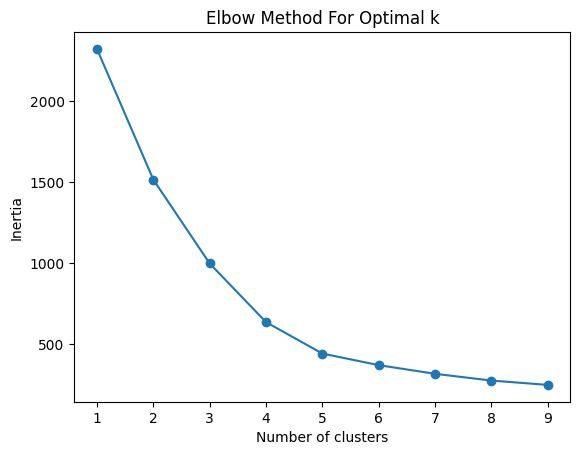

/opt/tljh/user/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
          ulcscode  StudentEnrollment     ELCount      ELPCT  NotELCount  \
count   150.000000         150.000000   99.000000  99.000000   99.000000   
mean   4183.160000         400.920000    9.868687   3.158283  271.949495   
std    2025.563023         240.156451   14.347471   3.385769  138.344835   
min    1010.000000           1.000000    0.000000   0.000000    1.000000   
25%    3312.500000         234.500000    3.000000   1.135000  194.000000   
50%    3427.500000         334.000000    5.000000   2.020000  262.000000   
75%    5577.500000         559.750000   13.000000   3.600000  337.500000   
max    8900.000000        1185.000000  114.000000  21.670000  759.000000   

         NotELPCT    IEPCount      IEPPCT  NotIEPCount   NotIEPPCT  ...  \
count   99.000000  150.000000  150.000000   150.000000  150.000000  ...   
mean    96.841717   90.193333   22.676733   310.726667   77.323333  ...   
std      3.385769   64.478985   10.535708   185.673449   10.535753  ...   
min 

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Let's assume your DataFrame 'education_merged_df' is already loaded and looks like the image you provided

# Step 1: Preprocess the Data (if necessary)
# If the data is already between 0 and 1, you may skip this step
scaler = StandardScaler()
scaled_features = scaler.fit_transform(education_merged_df[['AsianPCT', 'BlackAfricanAmericanPCT', 'HispanicPCT', 'WhitePCT']])

# Step 2: Choosing the Number of Clusters with the Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the inertia to see the 'elbow'
import matplotlib.pyplot as plt

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Step 3: Clustering
# After determining the elbow point, say it's 3 for example
optimal_clusters = 5  # replace with the number you find from the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=1)
education_merged_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 4: Analysis
# Explore the clusters
for i in range(optimal_clusters):
    print(f"Cluster {i}:")
    cluster_data = education_merged_df[education_merged_df['Cluster'] == i]
    print(cluster_data.describe())


In [26]:
# Assuming 'education_merged_df' already has the 'Cluster' column from the previous KMeans operation

# Display school names alongside their cluster labels
clustered_schools = education_merged_df[['Zip Code', 'Cluster']]
print(clustered_schools)

# Loop through each cluster and print the schools in each one
number_of_clusters = education_merged_df['Cluster'].nunique()  # Or however many clusters you specified in KMeans

for i in range(number_of_clusters):
    print(f"Zip Codes in Cluster {i}:")
    schools_in_cluster = education_merged_df[education_merged_df['Cluster'] == i]['Zip Code']
    print(schools_in_cluster.to_list())
    print("\n")

     Zip Code  Cluster
0         NaN        0
1     19143.0        1
2     19154.0        3
3     19148.0        1
4     19136.0        1
..        ...      ...
575       NaN        1
576       NaN        1
577       NaN        1
578       NaN        1
579       NaN        1

[580 rows x 2 columns]
Schools in Cluster 0:
[nan, nan, 19121.0, 19151.0, 19143.0, 19139.0, nan, 19139.0, 19138.0, 19144.0, nan, nan, nan, 19143.0, nan, 19138.0, 19104.0, 19145.0, 19131.0, 19132.0, nan, 19121.0, 19131.0, 19140.0, 19119.0, 19126.0, 19120.0, 19121.0, 19104.0, nan, 19150.0, 19103.0, nan, nan, nan, nan, nan, 19131.0, nan, 19104.0, 19150.0, nan, nan, 19104.0, 19121.0, 19141.0, 19122.0, 19139.0, nan, nan, 19144.0, nan, 19142.0, 19150.0, 19142.0, nan, nan, nan, 19131.0, nan, 19139.0, nan, nan, nan, 19128.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 19143.0, nan, nan, 19123.0, nan, nan, 19121.0, 19151.0, 19151.0, 19131.0, nan, 19139.0, 19122.0, nan

In [27]:
#Filter down to just Pennslyvania
print(len(education_merged_df))
print(education_merged_df['School Name'].nunique())
for column in education_merged_df.columns:
    print(column)
# print(for column in education_merged_df.columns)

580
487
SchoolYear
Sector_x
SubSector
ulcscode
School Name
LearningNetwork
GradeLevel
StudentEnrollment
ELCount
ELPCT
NotELCount
NotELPCT
IEPCount
IEPPCT
NotIEPCount
NotIEPPCT
FemaleCount
FemalePCT
MaleCount
MalePCT
AmericanIndianCount
AmericanIndianPCT
AsianCount
AsianPCT
BlackAfricanAmericanCount
BlackAfricanAmericanPCT
HispanicCount
HispanicPCT
MultiRaceCount
MultiRacePCT
PacificIslanderCount
PacificIslanderPCT
WhiteCount
WhitePCT
CEPEconomicallyDisadvantagedRate
PA Code
NSC Code
NCES Code
AUN Code
ULCS Code_x
SRC School ID
Publication Name
Publication Name Alpha List
Abbreviated Name
Year Opened
School Level
Admission Type
Current Grade Span Served
Grade Span at Scale
Phasing-In
Phasing-Out
Governance
Management Organization
School Reporting Category
Alternate Education Type
Major Intervention
Major Intervention Year
Community School Cohort
CTE Status
Title I Designation
Federal Accountability Designation
City Council District
GPS Location
Multiple Addresses
Street Address
City
Sta

In [28]:
#Filter data down to radius of 15 miles (see list of generate zip codes)
print(education_merged_df.head(5))

  SchoolYear  Sector_x SubSector  ulcscode  \
0  2023-2024  District  District    6090.0   
1        NaN       NaN       NaN       NaN   
2  2023-2024  District  District    8390.0   
3        NaN       NaN       NaN       NaN   
4  2023-2024  District  District    8010.0   

                                         School Name LearningNetwork  \
0  a. philip randolph career and technical high s...      Network 13   
1                             a.d. harrington school             NaN   
2                            a.l. fitzpatrick school       Network 8   
3                      a.s. jenks academics plus sch             NaN   
4                        abraham lincoln high school       Network 4   

   GradeLevel  StudentEnrollment  ELCount  ELPCT  ...  Sector_y  ULCS Code  \
0  All Grades              436.0     15.0   3.44  ...  District     6090.0   
1         NaN                NaN      NaN    NaN  ...       NaN        NaN   
2  All Grades              791.0    125.0  15.80  ...  D

In [17]:
columns_to_keep = ["ulcscode", "School Name", "StudentEnrollment", "FemalePCT", "MalePCT", "AmericanIndianPCT", "AsianPCT", "BlackAfricanAmericanPCT", 
                     "HispanicPCT", "MultiRacePCT", "PacificIslanderPCT", "WhitePCT", "CEPEconomicallyDisadvantagedRate", "PA Code", 
                     "NSC Code", "NCES Code", "AUN Code", "ULCS Code_x", "SRC School ID", "City", "State", "Zip Code", "Number of Graduates", 
                     "First-Fall Matriculation Rate", "Average Daily Attendance (YTD)", "average_score"]
education_merged_df = education_merged_df[columns_to_keep]
education_merged_df = education_merged_df.dropna(subset=['Zip Code'])
education_merged_df.head(5)

,ulcscode,School Name,StudentEnrollment,FemalePCT,MalePCT,AmericanIndianPCT,AsianPCT,BlackAfricanAmericanPCT,HispanicPCT,MultiRacePCT,...,AUN Code,ULCS Code_x,SRC School ID,City,State,Zip Code,Number of Graduates,First-Fall Matriculation Rate,Average Daily Attendance (YTD),average_score
1,NaN,a.d. harrington school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126515001.0,1300.0,130,PHILADELPHIA,PA,19143.0,NaN,NaN,NaN,NaN
2,8390.0,a.l. fitzpatrick school,791.0,45.89,54.11,0.00,8.72,26.80,18.71,4.68,...,126515001.0,8390.0,839,PHILADELPHIA,PA,19154.0,NaN,NaN,89.75,NaN
3,NaN,a.s. jenks academics plus sch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126515001.0,2520.0,252,PHILADELPHIA,PA,19148.0,NaN,NaN,NaN,NaN
4,8010.0,abraham lincoln high school,2175.0,42.57,57.38,0.37,6.07,32.18,39.45,4.46,...,126515001.0,8010.0,801,PHILADELPHIA,PA,19136.0,336.0,29.46,82.99,NaN
6,2620.0,academy at palumbo,1188.0,58.25,41.33,0.34,36.11,24.92,17.26,5.13,...,126515001.0,2620.0,262,PHILADELPHIA,PA,19147.0,323.0,76.78,94.79,NaN


In [18]:
columns_to_keep = [ "School Name", "StudentEnrollment", "AsianPCT", "BlackAfricanAmericanPCT", 
                     "HispanicPCT", "WhitePCT", 
                       "City", "State", "Zip Code", "Number of Graduates", "Average Daily Attendance (YTD)", "average_score"]
education_merged_df = education_merged_df[columns_to_keep]
education_merged_df = education_merged_df.dropna(subset=['Zip Code'])
education_merged_df.head(20)

,School Name,StudentEnrollment,AsianPCT,BlackAfricanAmericanPCT,HispanicPCT,WhitePCT,City,State,Zip Code,Number of Graduates,Average Daily Attendance (YTD),average_score
1,a.d. harrington school,NaN,NaN,NaN,NaN,NaN,PHILADELPHIA,PA,19143.0,NaN,NaN,NaN
2,a.l. fitzpatrick school,791.0,8.72,26.80,18.71,40.96,PHILADELPHIA,PA,19154.0,NaN,89.75,NaN
3,a.s. jenks academics plus sch,NaN,NaN,NaN,NaN,NaN,PHILADELPHIA,PA,19148.0,NaN,NaN,NaN
4,abraham lincoln high school,2175.0,6.07,32.18,39.45,17.15,PHILADELPHIA,PA,19136.0,336.0,82.99,NaN
6,academy at palumbo,1188.0,36.11,24.92,17.26,16.25,PHILADELPHIA,PA,19147.0,323.0,94.79,NaN
8,achieve academy,50.0,0.00,92.00,8.00,0.00,PHILADELPHIA,PA,19121.0,NaN,NaN,NaN
9,achieve academy east,55.0,1.82,67.27,27.27,0.00,PHILADELPHIA,PA,19140.0,NaN,NaN,NaN
10,ad prima charter school,576.0,0.69,92.88,1.91,0.69,PHILADELPHIA,PA,19151.0,NaN,NaN,NaN
11,add b. anderson school,371.0,0.27,93.53,3.77,0.81,PHILADELPHIA,PA,19143.0,NaN,85.07,NaN
12,alain locke school,261.0,8.43,77.39,8.05,1.92,PHILADELPHIA,PA,19139.0,NaN,85.40,NaN


In [19]:
# filtering only the zip codes inside 15 miles of radius of 19140
import json
file_path = '../Team-7/zipcodes_within_radius.json'
with open(file_path, 'r') as file:
    data = json.load(file)

zip_codes_list = [int(item['zip_code']) for item in data['zip_codes']]
education_merged_df = education_merged_df[education_merged_df['Zip Code'].isin(zip_codes_list)]
print(len(education_merged_df))

FileNotFoundError: [Errno 2] No such file or directory: '../Team-7/zipcodes_within_radius.json'

In [ ]:
# finding the data of the 19140 zip code
row_19140 = education_merged_df[education_merged_df['Zip Code'] == '19140']
print(row_19140)

In [43]:
#Adding in educational data
#master_school_list_renamed = master_school_list.rename({'Zip Code' : 'ZIP'}, axis=1)
#master_school_list_renamed.head(10)
#master_school_list_renamed.

#merged_school_info = pd.merge(master_school_list, merged_census, on='ZIP'



In [ ]:
#Filter down to just Pennslyvania

In [ ]:
#Filter down the number of parameters in our data (some of these features are not necessarily the most important!)




In [ ]:
#Average the schools within each zip code



In [ ]:
#Filter data down to radius of 15 miles (see list of generate zip codes)